Next Word Prediction (also called Language Modeling) is the task of predicting what word comes next. It is one of the fundamental tasks of NLP.

* a prediction model using Bidirectional LSTM (Long short-term memory) model that will predict next words of sentence.

In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

E:\Anaconda\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


This dataset contains information about randomly chosen medium articles published in 2019 from these 7 publications:

Towards Data Science

UX Collective

The Startup

The Writing Cooperative

Data Driven Investor

Better Humans

Better Marketing

In [2]:
medium_data = pd.read_csv('medium_data.csv')
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [3]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


 use title field for predicting next word.

In [4]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

**Removing unwanted characters and words in titles**
Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.

In [5]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

#### Tokenzation
Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.

In [6]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)

Total number of words:  8238


### 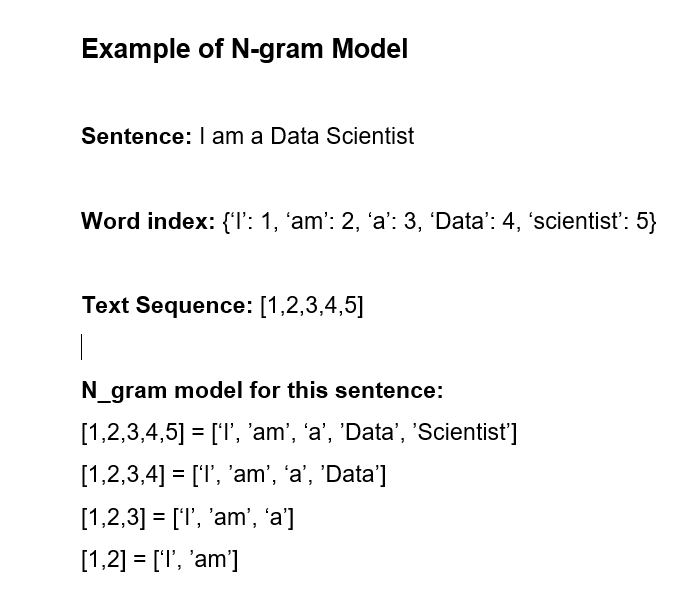Titles text into sequences and make n_gram model

In [7]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


In [8]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68])

#### need to perform onehot encoding on labels corresponding to total_words.

In [9]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)

## Architecture of Bidirectional LSTM Neural network

Long Short-Term Memory (LSTM) networks is an advance recurrent neural network which is apable to store order states by using its cell state feature.

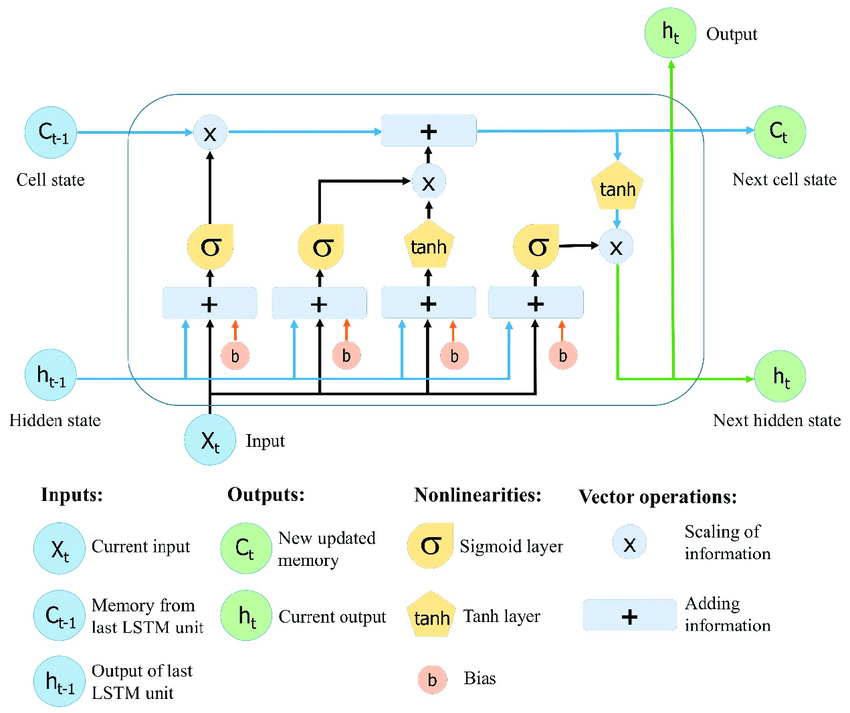

In [10]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=20, verbose=1)
#print model.summary()
print(model)

E:\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
1515/1515 [==============================] - 125s 81ms/step - loss: 6.7639 - accuracy: 0.1265
Epoch 2/20
1515/1515 [==============================] - 137s 91ms/step - loss: 5.7567 - accuracy: 0.1777
Epoch 3/20
1515/1515 [==============================] - 135s 89ms/step - loss: 4.9373 - accuracy: 0.2085
Epoch 4/20
1515/1515 [==============================] - 127s 84ms/step - loss: 4.1911 - accuracy: 0.2520
Epoch 5/20
1515/1515 [==============================] - 128s 85ms/step - loss: 3.6355 - accuracy: 0.3031
Epoch 6/20
1515/1515 [==============================] - 121s 80ms/step - loss: 3.2673 - accuracy: 0.3451
Epoch 7/20
1515/1515 [==============================] - 121s 80ms/step - loss: 3.0430 - accuracy: 0.3725
Epoch 8/20
1515/1515 [==============================] - 120s 80ms/step - loss: 2.8615 - accuracy: 0.3953
Epoch 9/20
1515/1515 [==============================] - 121s 80ms/step - loss: 2.7378 - accuracy: 0.4146
Epoch 10/20
1515/1515 [==============================] 

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

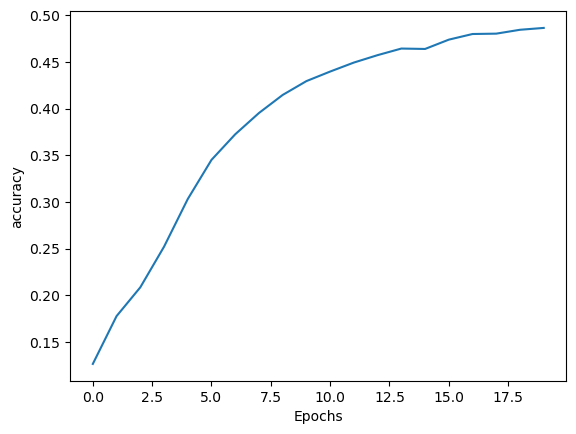

In [12]:
plot_graphs(history, 'accuracy')

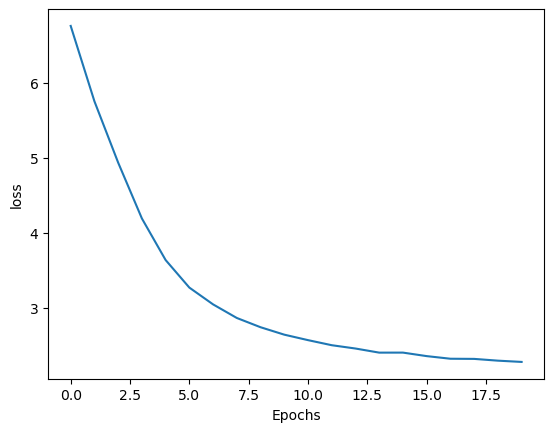

In [13]:
plot_graphs(history, 'loss')

In [20]:
seed_text = "Hi"
next_words = 2
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list),axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

Hi i’m ambiguity
